## Binary classification with Logistic regression 

### import libraries 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pymysql
from sqlalchemy import create_engine


### connection to sql 

In [4]:
#connection string
connection_string = 'mysql+pymysql://root:' + 'coding' + '@localhost/bank'
engine = create_engine(connection_string)


In [26]:
#query as a df
df= pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
DATEDIFF(19981231, convert(a.date,date)) as ageindays, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where l.status in('A','B') and dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, DATEDIFF(19981231, convert(a.date,date)),
 dp.type, round((l.amount-l.payments)/l.amount,2)
''', engine)


In [27]:
#use head to confirm the df works as expected 

df.head

<bound method NDFrame.head of      loan_id status  nooftrans  ageindays  95unemp  96unemp   type  \
0       4959      A        374       2134     0.29     0.43  OWNER   
1       4961      B        259       1364     1.51     2.07  OWNER   
2       4962      A        225        886     4.09     4.72  OWNER   
3       4973      A        295       1534     1.12     1.54  OWNER   
4       4986      A        209        970     4.75     5.44  OWNER   
..       ...    ...        ...        ...      ...      ...    ...   
229     7264      A        126        688     0.29     0.43  OWNER   
230     7277      A        128        694     0.29     0.43  OWNER   
231     7284      A        368       2177     3.13     3.60  OWNER   
232     7305      A        303       1552     4.76     5.74  OWNER   
233     7308      A        244       1174     5.77     6.55  OWNER   

     loanamount  birth_number  crime95  crime96  ratiopaid  
0         80952        450204    85677    99107       0.96  
1      

### EDA - exploratory data analysis - get to know the data 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_id       234 non-null    int64  
 1   status        234 non-null    object 
 2   nooftrans     234 non-null    int64  
 3   ageindays     234 non-null    int64  
 4   95unemp       234 non-null    float64
 5   96unemp       234 non-null    float64
 6   type          234 non-null    object 
 7   loanamount    234 non-null    int64  
 8   birth_number  234 non-null    int64  
 9   crime95       234 non-null    int64  
 10  crime96       234 non-null    int64  
 11  ratiopaid     234 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 22.1+ KB


In [29]:
df.describe()

,loan_id,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,6233.803419,317.794872,1633.615385,2.867735,3.519487,98143.435897,579128.367521,17469.858974,19639.179487,0.945513
std,680.590147,101.515938,458.123807,1.986507,2.266641,72013.383242,129120.756354,29906.361998,34746.947993,0.023290
min,4959.000000,108.000000,550.000000,0.000000,0.430000,4980.000000,350721.000000,0.000000,888.000000,0.920000
25%,5684.750000,228.250000,1224.250000,1.390000,1.960000,45039.000000,465172.000000,2157.500000,2252.000000,0.920000
50%,6300.000000,336.500000,1847.500000,2.790000,3.600000,80646.000000,580767.000000,3804.000000,3894.000000,0.960000
75%,6756.750000,389.500000,2029.750000,4.090000,4.772500,126960.000000,685783.750000,9878.000000,10108.000000,0.960000
max,7308.000000,548.000000,2178.000000,7.340000,9.400000,464520.000000,805709.000000,85677.000000,99107.000000,0.980000


In [30]:
df.dtypes

loan_id           int64
status           object
nooftrans         int64
ageindays         int64
95unemp         float64
96unemp         float64
type             object
loanamount        int64
birth_number      int64
crime95           int64
crime96           int64
ratiopaid       float64
dtype: object

In [31]:
df['status'].value_counts()

A    203
B     31
Name: status, dtype: int64

### histograms or boxplots



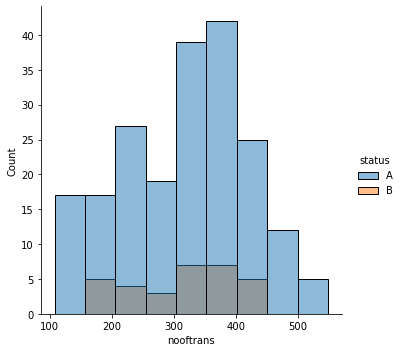

In [32]:
sns.displot(df, x='nooftrans', hue='status')

<AxesSubplot:xlabel='loanamount', ylabel='status'>

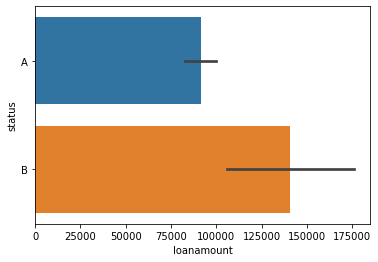

In [18]:
sns.barplot(x='loanamount', y='status', data=df)

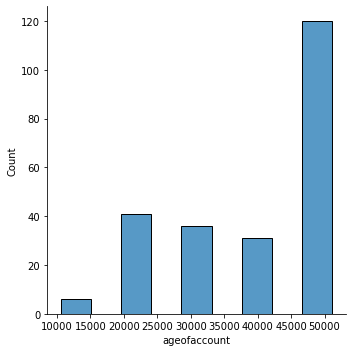

In [20]:
sns.displot(df['ageofaccount'])

### Check for multicollinearity 

In [24]:
correlation = df.corr()
correlation

,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
loan_id,1.000000,0.108456,0.076456,-0.083545,-0.078858,0.082673,0.151662,0.144176,0.143709,0.120034
nooftrans,0.108456,1.000000,0.880112,-0.107024,-0.142902,0.200899,0.085988,0.061994,0.062902,0.353508
ageofaccount,0.076456,0.880112,1.000000,-0.146500,-0.185622,0.285886,0.063039,0.049172,0.049698,0.456264
95unemp,-0.083545,-0.107024,-0.146500,1.000000,0.953504,-0.012914,0.055640,-0.534407,-0.540018,-0.049599
96unemp,-0.078858,-0.142902,-0.185622,0.953504,1.000000,-0.009944,0.041388,-0.568564,-0.572576,-0.050709
loanamount,0.082673,0.200899,0.285886,-0.012914,-0.009944,1.000000,0.008705,-0.007111,-0.005546,0.596621
birth_number,0.151662,0.085988,0.063039,0.055640,0.041388,0.008705,1.000000,-0.019644,-0.019462,0.034583
crime95,0.144176,0.061994,0.049172,-0.534407,-0.568564,-0.007111,-0.019644,1.000000,0.999728,0.018829
crime96,0.143709,0.062902,0.049698,-0.540018,-0.572576,-0.005546,-0.019462,0.999728,1.000000,0.020247
ratiopaid,0.120034,0.353508,0.456264,-0.049599,-0.050709,0.596621,0.034583,0.018829,0.020247,1.000000


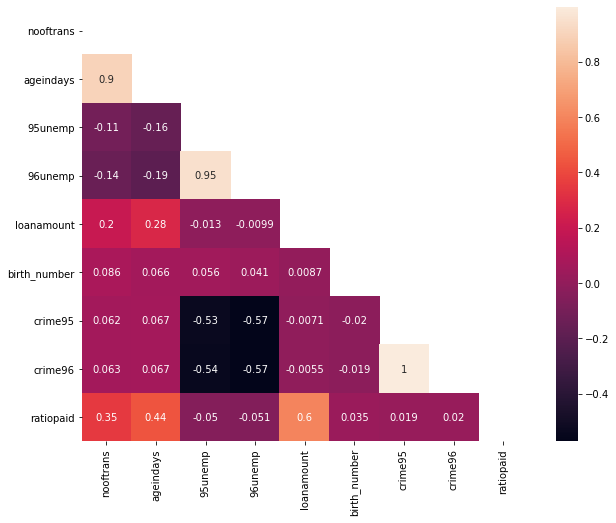

In [86]:
corr_matrix=df.corr(method='pearson')
fig,ax=plt.subplots(figsize=(10,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax=sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

### Clean and wrangling steps 

In [87]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
# bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 

#feature engineering - take the columns and make more useful 



# split the data into num and cat --- > diff options cleaning / scaling 

In [ ]:
#Extract gender


In [37]:
df.drop(['loan_id','type'], axis=1, inplace=True)

In [38]:
df.head()

,status,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,A,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,B,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,A,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,A,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,A,209,970,4.75,5.44,102876,420128,18782,18347,0.92


### Pre processing 

In [ ]:
# label / encode categorical columns 

# scale numerical columns 



In [39]:
cat = df.select_dtypes(include=object)
cat.head()

,status
0,A
1,B
2,A
3,A
4,A


In [43]:
categorical=pd.get_dummies(cat,columns=['status'],drop_first=True)
categorical.head()

,status_B
0,0
1,1
2,0
3,0
4,0


In [50]:
#numerical scaling

from sklearn.preprocessing import Normalizer

In [47]:
#select numerial features
x = df.select_dtypes(include=np.number)
x.head()

,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,209,970,4.75,5.44,102876,420128,18782,18347,0.92


In [53]:
scaler = Normalizer().fit(x)
scaled = scaler.transform(x)
scaled

array([[7.86012150e-04, 4.48489286e-03, 6.09474662e-07, ...,
        1.80061933e-01, 2.08286915e-01, 2.01757129e-06],
       [6.53056788e-04, 3.43926432e-03, 3.80739672e-06, ...,
        5.79682454e-03, 5.93550456e-03, 2.31973840e-06],
       [3.62317924e-04, 1.42672747e-03, 6.58613471e-06, ...,
        9.05472751e-03, 9.47984720e-03, 1.48147774e-06],
       ...,
       [5.02643230e-04, 2.97351715e-03, 4.27519921e-06, ...,
        2.52004554e-03, 2.56648541e-03, 1.25660808e-06],
       [4.43915356e-04, 2.27378426e-03, 6.97371978e-06, ...,
        3.09422188e-03, 3.01657332e-03, 1.34786181e-06],
       [3.81684646e-04, 1.83646629e-03, 9.02590332e-06, ...,
        5.07452866e-03, 4.81642224e-03, 1.50171008e-06]])

In [ ]:
#Id you had more categorical features thasn just label in status then we would just concat
# X=np.concatenate([scaled_X,categorical],axis=1)

### split off the dependant variable (label)

In [61]:
# y = depependent variable  (status library)

X = scaled
y = categorical['status_B']


### train test split, get LOG REG model

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=40)

## apply model and train model 

In [67]:
classification = LogisticRegression(solver='liblinear',multi_class='ovr').fit(X_train,y_train)

In [ ]:
#add to the parameters as wished

### evaluate accuracy and test 

In [71]:
import sklearn.metrics as metrics
probabilities = classification.predict_proba(X_test)
preds = probabilities[:,1]
fpr,tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.7817460317460317


#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

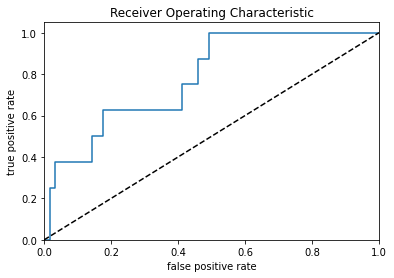

In [73]:
#roc curve plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()

### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [81]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

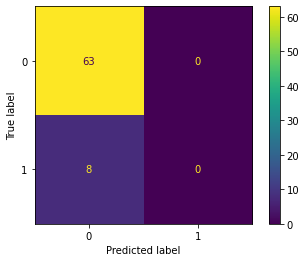

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

### data is highly imbalanced

this is affecting the accuracy of our predictions 
- what can be done to resolve that ?


+ option 1 - SMOTE 

+ option 2 - TOMEK LINKS 

